In [1]:
import time
import biosppy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.signal import lfilter
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm 

from sliding.ecg_slider import ECGSlider
from sliding.slider import Slider
from statistic.wasserstein_distance import WassersteinDistance, WassersteinDistanceDeviation
from transform.indexed_transform import IndexedTransformer
from transform.interpolate import SplineInterpolate
from transform.pca import PCATransformer
from transform.scale import ScaleTransform
from transform.series_to_curve import CurveProjection, IndicesWindow
from transform.transformer import SequentialTransformer
from transform.triangle_pattern import TrianglePattern
from Bootstrap.wasserstein_bootstrap import wasserstein_computation
from func.Functions import chunkIt
from func.Functions import std_mean_change
from func.Functions import index_to_series
from func.Functions import annotations
from func.Functions import recall
from func.Functions import accuracy
from func.Functions import specifity
from func.Functions import  true_labels 
from func.Functions import  arrhythmia_index 
from func.Functions import  arrhythmia_index_check 
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score


from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import pickle
#import ot
from abc import ABC, abstractmethod

In [2]:
from add_func import save_pkl
from add_func import shape_changes
from add_func import features_vectors_
from add_func import metric
from add_func import predict
from add_func import distances_calculations
from add_func import wasserstein_computation
from add_func import weights_
from add_func import features_create


In [3]:
curves=pd.read_pickle('data/curves_2_wind_100.pkl')#read curves
clusters_new=pd.read_pickle('data/clust_fin.pkl')#read clusters labels


curves_tensors=[]
for curve in range (len(curves)):
  curves_tensors.append(torch.from_numpy(curves[curve]))

max_shape=np.max(np.unique(list(map(len, curves))))
new_curves=[]
for i in range(len(curves)):
    new=np.zeros((max_shape,3))
    new[:curves[i].shape[0],:3]=curves[i]
    new_curves.append(new)
    
tensor_set=torch.stack([torch.Tensor(i) for i in new_curves[:-1]])

clusters_1=[]
for i,cl in enumerate(clusters_new):
  s=pd.DataFrame(cl)
  s['label']=[i]*len(s)
  clusters_1.append(s)
    
res_1=pd.concat(clusters_1)
res_1=res_1.drop_duplicates(0)
res_1=res_1.sort_values(0)

labels=np.array(res_1['label'])

labels=torch.Tensor(labels[:-1])

In [4]:
from model.Encoder import Encoder
device = torch.device('cpu')
model = Encoder()
model.load_state_dict(torch.load('model/weights_clusters/params_model_simple_auto_clust_101.ckpt', map_location='cpu'))#read weights


<All keys matched successfully>

In [5]:

features=features_create(model,tensor_set)

100%|██████████| 4868/4868 [00:06<00:00, 797.06it/s]


In [6]:
first_cluster=np.where(labels==0)[0]
second_cluster=np.where(labels==1)[0]
third_cluster=np.where(labels==2)[0]
four_cluster=np.where(labels==3)[0]
fifth_cluster=np.where(labels==4)[0]
six_cluster=np.where(labels==5)[0]
seven_cluster=np.where(labels==6)[0]

first_cluster=[features[int(i)] for i in first_cluster]
second_cluster=[features[int(i)] for i in second_cluster]
third_cluster=[features[int(i)] for i in third_cluster]
four_cluster=[features[int(i)] for i in four_cluster]
fifth_cluster=[features[int(i)] for i in fifth_cluster]
six_cluster=[features[int(i)] for i in six_cluster]
seven_cluster=[features[int(i)] for i in seven_cluster]

clusters=[first_cluster,second_cluster,third_cluster,four_cluster,fifth_cluster,six_cluster,seven_cluster]

# Binary Classification

In [7]:
first_cluster_train=first_cluster[:int(0.8*len(first_cluster))]
second_cluster_train=second_cluster[:int(0.8*len(second_cluster))]
third_cluster_train=third_cluster[:int(0.8*len(third_cluster))]
four_cluster_train=four_cluster[:int(0.8*len(four_cluster))]
fifth_cluster_train=fifth_cluster[:int(0.8*len(fifth_cluster))]
six_cluster_train=six_cluster[:int(0.8*len(six_cluster))]
seven_cluster_train=seven_cluster[:int(0.8*len(seven_cluster))]

first_cluster_test=first_cluster[int(0.8*len(first_cluster)):]
second_cluster_test=second_cluster[int(0.8*len(second_cluster)):]
third_cluster_test=third_cluster[int(0.8*len(third_cluster)):]
four_cluster_test=four_cluster[int(0.8*len(four_cluster)):]
fifth_cluster_test=fifth_cluster[int(0.8*len(fifth_cluster)):]
six_cluster_test=six_cluster[int(0.8*len(six_cluster)):]
seven_cluster_test=seven_cluster[int(0.8*len(seven_cluster)):]



first_train=np.concatenate((first_cluster_train,second_cluster_train))
second_train=np.concatenate((third_cluster_train,four_cluster_train,fifth_cluster_train, six_cluster_train,seven_cluster_train))

first_test=np.concatenate((first_cluster_test,second_cluster_test))
second_test=np.concatenate((third_cluster_test,four_cluster_test,fifth_cluster_test, six_cluster_test,seven_cluster_test))

train_=[first_train,second_train]
test_c=[first_test,second_test]

In [8]:
y_train=torch.Tensor([0,1])
def target_creation(y_train,train_):
  targets_train=[]
  for i,j in zip(y_train,train_):
    targets_train.append(torch.zeros(len(j)).resize(len(j),1).fill_(i))
  return targets_train

train_targets=target_creation(y_train,train_)
test_targets=target_creation(y_train,test_c)


In [9]:
train=np.concatenate(train_)
test=np.concatenate(test_c)
train_target=np.concatenate(train_targets)
test_target=np.concatenate(test_targets)
train=train.reshape(train.shape[0],train.shape[-1])
test=test.reshape(test.shape[0],test.shape[-1])

In [10]:
from sklearn.neighbors import KNeighborsClassifier
svm_binary = KNeighborsClassifier(n_neighbors=8,algorithm='kd_tree').fit(train, train_target)
# svm_binary = SVC(probability=True).fit(train, train_target)
y_pred_train=svm_binary.predict(train)
y_pred_test=svm_binary.predict(test)
y_pred_train_proba=svm_binary.predict_proba(train)
y_pred_test_proba=svm_binary.predict_proba(test)


print(accuracy_score(y_pred_train,train_target))
print(f1_score(y_pred_train,train_target))

print(accuracy_score(y_pred_test,test_target))
print(f1_score(y_pred_test,test_target))
print(roc_auc_score(y_pred_test,test_target))
print(roc_auc_score(test_target,y_pred_test_proba[:,1]))

0.8741007194244604
0.8737113402061855
0.8278688524590164
0.8435754189944134
0.8255266544740228
0.8778142908157192


# Multiclass classification

In [17]:
first_cluster_train=first_cluster[:int(0.8*len(first_cluster))]
second_cluster_train=second_cluster[:int(0.8*len(second_cluster))]
third_cluster_train=third_cluster[:int(0.8*len(third_cluster))]
four_cluster_train=four_cluster[:int(0.8*len(four_cluster))]
fifth_cluster_train=fifth_cluster[:int(0.8*len(fifth_cluster))]
six_cluster_train=six_cluster[:int(0.8*len(six_cluster))]
seven_cluster_train=seven_cluster[:int(0.8*len(seven_cluster))]

first_cluster_test=first_cluster[int(0.8*len(first_cluster)):]
second_cluster_test=second_cluster[int(0.8*len(second_cluster)):]
third_cluster_test=third_cluster[int(0.8*len(third_cluster)):]
four_cluster_test=four_cluster[int(0.8*len(four_cluster)):]
fifth_cluster_test=fifth_cluster[int(0.8*len(fifth_cluster)):]
six_cluster_test=six_cluster[int(0.8*len(six_cluster)):]
seven_cluster_test=seven_cluster[int(0.8*len(seven_cluster)):]

train_=[first_cluster_train,second_cluster_train,third_cluster_train,four_cluster_train,fifth_cluster_train,six_cluster_train,seven_cluster_train]
test_c=[first_cluster_test,second_cluster_test,third_cluster_test,four_cluster_test,fifth_cluster_test,six_cluster_test,seven_cluster_test]

In [18]:
y_train=torch.Tensor([0,1,2,3,4,5,6])
def target_creation(y_train,train_):
  targets_train=[]
  for i,j in zip(y_train,train_):
    targets_train.append(torch.zeros(len(j)).resize(len(j),1).fill_(i))
  return targets_train

train_targets=target_creation(y_train,train_)
test_targets=target_creation(y_train,test_c)

In [19]:
train=np.concatenate(train_)
test=np.concatenate(test_c)
train_target=np.concatenate(train_targets)
test_target=np.concatenate(test_targets)
train=train.reshape(train.shape[0],train.shape[-1])
test=test.reshape(test.shape[0],test.shape[-1])

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [21]:
from sklearn.neighbors import KNeighborsClassifier
svm_multy = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5,algorithm='ball_tree')).fit(train, train_target)

y_pred_train=svm_multy.predict(train)
y_pred_test=svm_multy.predict(test)
y_pred_train_proba=svm_multy.predict_proba(train)
y_pred_test_proba=svm_multy.predict_proba(test)


print(accuracy_score(y_pred_train,train_target))
print(f1_score(y_pred_train,train_target,average='macro'))

print(accuracy_score(y_pred_test,test_target))
print(f1_score(y_pred_test,test_target,average='macro'))


0.7289311408016445
0.6266548156412192
0.4774590163934426
0.3549039610145609


In [11]:
dist=WassersteinDistance(2)


## Main part

In [12]:
plt.rcParams["figure.figsize"] = (10, 5)
data=pd.read_csv('mitdb/205.csv')
mlii: pd.Series = data.iloc[:, 1]
sig_arr = np.asarray(mlii.tolist())
ECG_parts=chunkIt(sig_arr,5)
mlii_parts=chunkIt(mlii,5)
sig=ECG_parts[0]
mli=mlii_parts[0]
# sig=sig[:120000]
# mli=mli[:120000]
sig_series=pd.Series(sig)
# sig_series.index=mli.index
projection_step = 1
smooth_transform = SequentialTransformer(
    ScaleTransform(0, 1),
    SplineInterpolate(0.02)
)

smooth_data = smooth_transform(sig)


In [13]:
 was,was_deviation_median,was_index,curves=wasserstein_computation(smooth_data,2,2,2)

547it [05:46,  1.58it/s]


In [15]:
f_vectors=features_vectors_(curves,model,0,tensor_set)



100%|██████████| 547/547 [00:00<00:00, 801.34it/s]


In [23]:
cluster_predictions_binary=svm_binary.predict(f_vectors)
cluster_predictions_multy=svm_multy.predict(f_vectors)


In [24]:
new_data=std_mean_change(was_deviation_median,was)

line2=np.quantile(new_data,0.95)
sep_line1=[line2]*len(sig_series)

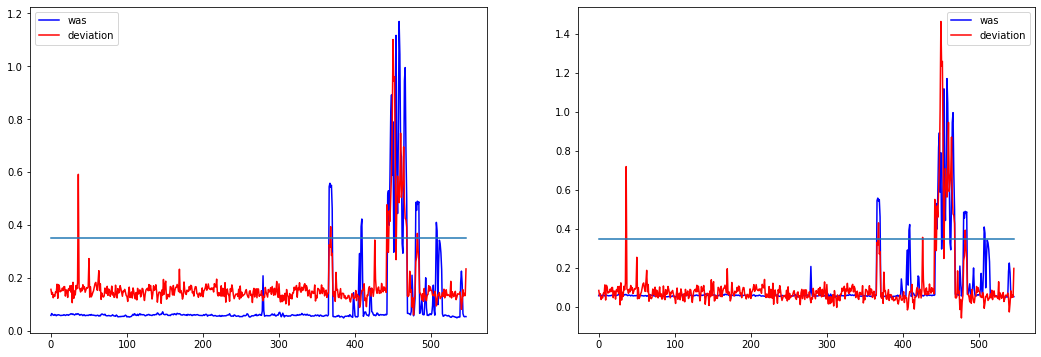

In [25]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(was,c='b',label='was')
plt.plot(was_deviation_median,c='r',label='deviation')
plt.plot([line2]*len(new_data))
plt.legend()
plt.subplot(122)
plt.plot(was,c='b',label='was')
plt.plot(new_data,c='r',label='deviation')
plt.plot([line2]*len(new_data))
plt.legend()

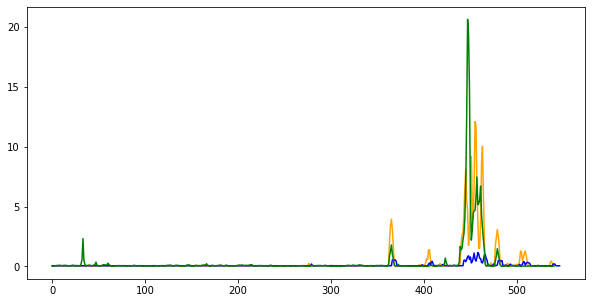

In [26]:
triangle = IndexedTransformer(TrianglePattern(7), padding=1, step=1)
tr_indices, tr_was = triangle(np.asarray(was))
tr_indices_dev, tr_was_dev = triangle(np.asarray(new_data))
final_indices = np.asarray(was_index)[tr_indices]
plt.plot(tr_was,c='orange')
plt.plot(was,c='b')
plt.plot(tr_was_dev,c='g')

In [27]:
f_i_d=np.array([])
ind=np.array([])
for i,j in enumerate(tr_was):
    #if max(tr_was)>=min(tr_was):
    if j>line2:
        f_i_d=np.append(j,f_i_d)
        ind=np.append(i,ind)
fin_ind=np.array([])
for i in ind:
    fin_ind=np.append(final_indices[int(i)],fin_ind)
f_i_d =f_i_d[::-1]

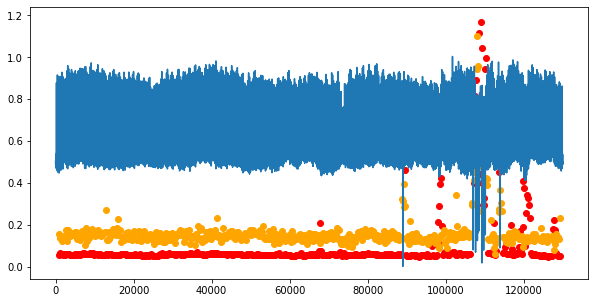

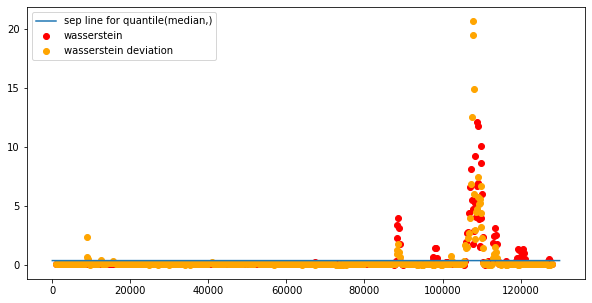

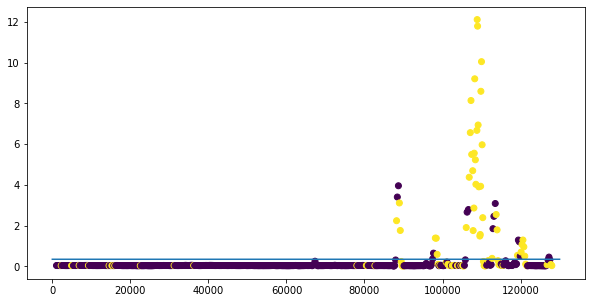

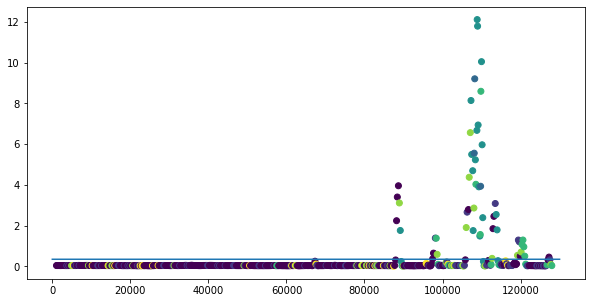

In [28]:
plt.plot(smooth_data)
plt.scatter(was_index, was, c="red")
plt.scatter(was_index, was_deviation_median, c="orange")
plt.show()

plt.scatter(final_indices, tr_was, c="red",label='wasserstein')
plt.scatter(final_indices, tr_was_dev, c="orange",label='wasserstein deviation')
plt.plot(sep_line1,label='sep line for quantile(median,)')
plt.legend()
plt.show()

plt.scatter(final_indices, tr_was, c=cluster_predictions_binary[:541])
plt.plot(sep_line1)
plt.show()

plt.scatter(final_indices, tr_was, c=cluster_predictions_multy[:541])
plt.plot(sep_line1)
plt.show()